In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /gdrive


In [ ]:
cd '../gdrive/MyDrive/SSAC/4조'

/gdrive/.shortcut-targets-by-id/1ds5uus_7-EPK6G7A6HjwhTVmFOXL6YtQ/4조


# 필요한 라이브러리 설치 및 import

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 1.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619432 sha256=0adcb9722b98e11b97b8696d25c0132d8ef3c68ac232ab42eb1f4dac8bec552c
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606656 sha256=4320285331fbc76525466be9367aaeb68a192074e6b5cbecdf63725a05fbdc2d
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [ ]:
from surprise import Dataset, Reader
from surprise import SVD
from google.colab import drive
from surprise import accuracy
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

# 데이터 준비

데이터 불러오기

In [ ]:
movie_df = pd.read_csv('코드/Dataset/data_keyword.csv',low_memory=False)
movie_df.fillna('', inplace=True)
rating_df = pd.read_csv('코드/Dataset/ratings_small.csv',low_memory=False)
#rating_full = pd.read_csv('코드/Dataset/ratings.csv',low_memory=False)
#rating_df = rating_full[rating_full['userId'] < 10000]

In [ ]:
movie_df.rename(columns={'id':'movieId'}, inplace=True)
user_movie_df = pd.merge(rating_df, movie_df, on = 'movieId')
user_movie_df.head(2)

,userId,movieId,rating,timestamp,cast_list,character_list,director,title,genres,overview,production_companies,release_date,keyword_list,keyword_list_no_space
0,1,1371,2.5,1260759135,SylvesterStallone TaliaShire BurtYoung CarlWea...,"RockyBalboa Adrianna""Adrian""PenninoBalboa Paul...",SylvesterStallone,Rocky III,Drama,"Now the world champion, Rocky Balboa is living...",United Artists,1980,transporter trainer boxer dying and death boxi...,transporter trainer boxer dyinganddeath boxing...
1,4,1371,4.0,949810302,SylvesterStallone TaliaShire BurtYoung CarlWea...,"RockyBalboa Adrianna""Adrian""PenninoBalboa Paul...",SylvesterStallone,Rocky III,Drama,"Now the world champion, Rocky Balboa is living...",United Artists,1980,transporter trainer boxer dying and death boxi...,transporter trainer boxer dyinganddeath boxing...


In [ ]:
# unique() 함수로 사용자 수와 영화 수 탐색
len(user_movie_df['userId'].unique())

671

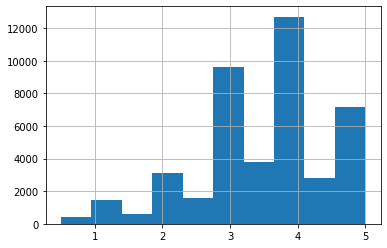

In [ ]:
# hist() 함수로 히스토그램 그래프 생성
user_movie_df['rating'].hist() #점수 분포 확인 -> 좋아보이는 분포

# Suprise

## 데이터 준비

사이킷런 train_test_split으로 train/test set 분리

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(user_movie_df, test_size=0.2)

사이킷런에서 나눈 데이터 surprise 형식에 맞게 변환

In [ ]:
# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
reader = Reader(rating_scale = (1,5)) # Reader: 레이팅 테이블을 분석하기 위한 클래스. user ; item ; rating ; [timestamp] 이런 구조로 된 테이블을 써야함. (1,5) : 레이팅 점수 범위
data = Dataset.load_from_df(user_movie_df[['userId', 'movieId', 'rating']], reader) #Dataset: 데이터 관리하는 클래스. 위에서 읽은 데이터중 시간을 빼고 읽음
#불러온 레이팅 데이터를 학습테스트 데이터 80프로 테스트 데이터 20프로로 분리
# train 데이터 프레임을 surprise.trainset 형식으로 변환
trainset = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader).build_full_trainset()
# 형식에 맞게 test set 생성
testset = []
for i in range(len(test)):
    testset.append((test['userId'].iloc[i], test['movieId'].iloc[i], test['rating'].iloc[i]))

## surprise 모델 학습

In [ ]:
# SVD 모델 학습
mf_model = SVD(n_factors = 10) #Surprise의 SVD학습을 위한 클래스. Latent Factor 수를 10개로 학습
mf_model.fit(trainset) #SVD 학습하기 -> #학습데이터로 Rating Matrix를 만들고 빈값을 채워넣는다.
predictions = mf_model.test(testset) #학습결과로 테스트 데이터 적용시켜보기 -> 학습데이터에서 채워넣은 빈값들 중에 테스트데이터로 분리된 값들이랑 겹치는 부분을 비교한다.

In [ ]:
predictions[:10] #학습 결과랑 테스트 결과 비교
#uid: User ID, iid: Movie ID, r_ui: 테스트 데이터에 있는 레이팅 값. est: 학습데이터에서 채워넣은 빈값
#즉 uid=109, iid=5445, r_ui=4.0, est=3.8877405057899215 뜻은 109번 유저의 5445번 영화에 대한 실제 평가는 4점이고 예측한 평가는 3.8877점이다

[Prediction(uid=119, iid=16, r_ui=3.0, est=3.9167264492324003, details={'was_impossible': False}),
 Prediction(uid=195, iid=2502, r_ui=3.0, est=3.299756844518024, details={'was_impossible': False}),
 Prediction(uid=607, iid=1396, r_ui=4.5, est=3.7082552571741942, details={'was_impossible': False}),
 Prediction(uid=370, iid=7445, r_ui=4.0, est=3.8510253307839903, details={'was_impossible': False}),
 Prediction(uid=162, iid=3, r_ui=2.0, est=3.1671122124568667, details={'was_impossible': False}),
 Prediction(uid=562, iid=1584, r_ui=4.0, est=4.078427250859578, details={'was_impossible': False}),
 Prediction(uid=177, iid=1259, r_ui=5.0, est=4.756044558785706, details={'was_impossible': False}),
 Prediction(uid=551, iid=336, r_ui=3.0, est=3.588835295152999, details={'was_impossible': False}),
 Prediction(uid=652, iid=442, r_ui=4.0, est=3.690052750517836, details={'was_impossible': False}),
 Prediction(uid=463, iid=2359, r_ui=3.0, est=3.8713985559878394, details={'was_impossible': False})]

In [ ]:
#Prediction의 값들을 좀 더 가독성 좋게 보기
for _, iid, r_ui, predicted_rating, _ in predictions[:10]:
    print("Item id", iid, "|", "real rating :", round(r_ui, 2), "|", "predicted rating :", round(predicted_rating, 2))

Item id 16 | real rating : 3.0 | predicted rating : 3.92
Item id 2502 | real rating : 3.0 | predicted rating : 3.3
Item id 1396 | real rating : 4.5 | predicted rating : 3.71
Item id 7445 | real rating : 4.0 | predicted rating : 3.85
Item id 3 | real rating : 2.0 | predicted rating : 3.17
Item id 1584 | real rating : 4.0 | predicted rating : 4.08
Item id 1259 | real rating : 5.0 | predicted rating : 4.76
Item id 336 | real rating : 3.0 | predicted rating : 3.59
Item id 442 | real rating : 4.0 | predicted rating : 3.69
Item id 2359 | real rating : 3.0 | predicted rating : 3.87


In [ ]:
#accuracy 함수로 rmse 평가
accuracy.rmse(predictions)
#즉, 모든 예측한 값과 각각의 실제값의 차이에 대한 RMSE(Root Mean Square Error)을 구한것
#0에 가까울 수록 전반적인 오차가 적다는 뜻

RMSE: 0.9024


0.902402588721435

## 최적의 latent factor 찾기

In [ ]:
%time
#Latent Factor 수를 조절하여 최상의 학습결과를 내는것을 찾음 -> 더많은 후보군
#param_list = [10, 50, 100, 150, 200] #Latent Factor 후보군
param_list = range(1, 10)
# param_list = [x for x in range(0,200,5)] #Latent Factor 후보군
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in param_list:    
    train_start = time.time() #학습에 걸린 시간을 측정하기위함
    mf_model = SVD(n_factors=n) #Latent Factor N개로 측정
    mf_model.fit(trainset) #학습하기
    train_end = time.time() #학습에 걸린 시간을 측정하기위함
    print("training time of model: %.2f seconds" % (train_end - train_start)) #걸린시간 출력
    print("RMSE of test dataset in SVD model, n_factors=" + str(n)) #Latent Factor N개에 대한 RMSE값 출력
    predictions = mf_model.test(testset) #학습된 모델에 테스트값 적용
    rmse_result = accuracy.rmse(predictions) #RMSE를 구해 평가
    rmse_list_by_factors.append(rmse_result) #RMSE 값 저장
    ttime_list_by_factors.append((train_end - train_start)) #측정된 시간 저장
    print("------------------------------------")
print("searching n_factors is finish.")

# #범위를 좁혀 했을때 15개가 성능이 제일 좋았다

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
training time of model: 0.57 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.9025
------------------------------------
training time of model: 0.61 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.9024
------------------------------------
training time of model: 0.67 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.9024
------------------------------------
training time of model: 0.67 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.9023
------------------------------------
training time of model: 0.69 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.9027
------------------------------------
training time of model: 0.65 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.9022
------------------------------------
training time of model: 0.62 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.9035
-----------------------------------

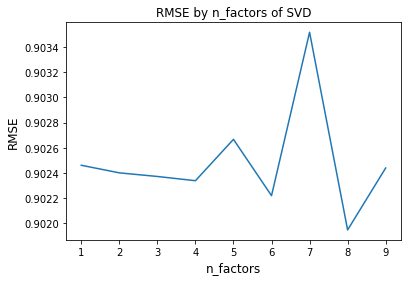

In [ ]:
# plt의 plot 함수로 결과 시각화
#위에 5~200개 중 5단위로 있는 Latent Factor들 중 가장 성능이 좋은것을 찾음 
plt.plot(param_list, rmse_list_by_factors) 
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

In [ ]:
print(param_list[rmse_list_by_factors.index(min(rmse_list_by_factors))]) #RMSE가 가장 낮게나온 Latent Factor수를 출력
#무조건 많다고 좋은게 아닌걸 알 수 있다
#많을수록 과적합이 일어나 성능이 더 낮아진다

8


## 시간순으로 데이터 나눠서 학습

In [ ]:
###################################################################################################
#                               시간순으로 데이터를 나눠 학습해보기                               #
###################################################################################################

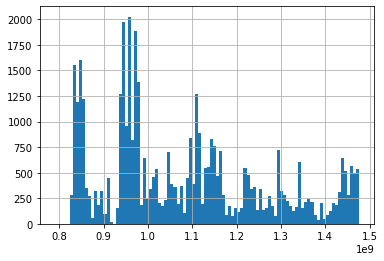

In [ ]:
user_movie_df['timestamp'].hist(bins=100) #유져별 각 영화 시청 시간의 분포를 알아보기

In [ ]:
# Quantile을 통해 전체 시간대 중 과거 80프로 미래 20프로로 나누는 특정 시간을 찾는다
that_time = user_movie_df['timestamp'].quantile(q=0.8, interpolation='nearest')
that_time

1256030057

In [ ]:
# 위에서 찾은 특정 시간으로 데이터를 나눈다
# 데이터를 8대 2로 나누는 시간이므로
# 전체데이터중 학습용 80프로 테스트용 20프로로 나뉜다
past_df = user_movie_df[user_movie_df['timestamp']< that_time][['userId','movieId','rating']]
future_df = user_movie_df[user_movie_df['timestamp'] >= that_time][['userId','movieId','rating']]

#여기서 과거용 데이터를 기준으로 위에서 한것처럼 학습을 시키고
#과거용 데이터에서 채워넣은 값들 (미래에 대한걸 예측한 값) 이랑 실제 미래값이랑 비교해본다.
#더 작은 학습데이터로 하기때문에 RMSE는 안좋아도 실제로는 더 현실적인 추천을 해줄 수 있다.

In [ ]:
past_df.shape #총 8만개의 시청 기록

(34618, 3)

In [ ]:
len(past_df['userId'].unique()), len(future_df['userId'].unique()) #학습엔 547명의 유저, #테스트엔 147명의 유저

(485, 209)

In [ ]:
future_data = []
for i in range(len(test)):
    future_data.append((future_df['userId'].iloc[i], future_df['movieId'].iloc[i], future_df['rating'].iloc[i]))

## 시간순으로 학습

In [ ]:
# 위에서 추출한 학습 데이터셋으로 SVD 모델 다시 학습
data = Dataset.load_from_df(df = past_df, reader = reader) #과거 데이터를 불러오기
train_data = data.build_full_trainset() #과거데이터에서 랜덤으로 학습할 것을 뽑음
test_data = train_data.build_anti_testset() # anti dataset 생성 -> 윗줄코드 과거데이터에서 학습데이터를 뽑은걸 바탕으로 테스트데이터를 추출
mf_model = SVD(n_factors = 10) #이전에 10이 가장 학습성능이 좋아서 10으로 진행
mf_model.fit(train_data)

In [ ]:
predictions = mf_model.test(test_data) #과거데이터에서 뽑은 학습데이터로 학습한걸로 과거데이터에서 뽑은 테스트데이터를 적용시켜봄

In [ ]:
estimated_unwatched_dict = {} #각 유저별 시청한 영화들에 대한 예측 평가 점수에 대한 리스트
#{ user id : [(movie id, predicted rating score]), ...}
#{1: [(10, 2.555), (17, 3.0455), ...], 
# 2:[(11, 3.xxx), (105, 4.xxxx), ...],
# .... }

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]


In [ ]:
# 미래 데이터 중에 4점 이상 평가 된 영화들중에
# 각 유저별로 4점이상 평가한 영화들에 대한 리스트를 만든다
user_watch_dict_list_test = future_df[future_df['rating']>=4].groupby('userId')[['userId', 'movieId']].apply(lambda x: x['movieId'].tolist())
user_watch_dict_list_test

userId
1                                                 [2105]
3      [110, 296, 318, 778, 1378, 1721, 1884, 2028, 2...
11                                 [296, 778, 1408, 923]
13     [110, 527, 590, 318, 58559, 1259, 1961, 277, 2...
15     [913, 2064, 48385, 1689, 1955, 2993, 3476, 748...
                             ...                        
652    [185, 223, 319, 339, 377, 539, 550, 588, 592, ...
655    [253, 296, 364, 588, 595, 2959, 58559, 1265, 3...
660    [58559, 260, 30707, 4993, 8961, 8970, 40815, 5...
663                                        [593, 134368]
664    [110, 223, 296, 377, 592, 593, 318, 778, 1580,...
Length: 204, dtype: object

In [ ]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in estimated_unwatched_dict:
  estimated_list = estimated_unwatched_dict[user].copy()
  estimated_list.sort(key=lambda tup: tup[1], reverse=True) #tup[1] 점수에 해당하는 부분. reverse -> 내림차순
  #유저별 영화에 대한 예측평가점수들을 내림차순으로 정렬함 (리스트가 점수에따라 정렬이 됨)
  try: 
    top_k_prefer_list = [movie[0] for movie in estimated_list[:k]] #유저별로 높게 평가했을거라고 예측된 상위 k의 영화를 가져옴
    actual_watch_list = user_watch_dict_list_test[int(user)] #실제로 본 영화평가중 4점 이상으로 평가한것
    user_metric.append((user, top_k_prefer_list, actual_watch_list)) # '유저'별로 '예측된 평가중 상위 k개'와 '실제로 4점이상준 영화'를 짝지어 user_metric 리스트에 튜플로 넣어줌
  except: #특정시점 이전엔 영화를 봤지만 특정시점 이후에는 영화를 안본 유저를 걸러주기 위함
    pass
    #print("list index out of range, exclude user " + str(user))

In [ ]:
# user metric를 인자로 받는 mean average precision 계산하는 함수
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1] #높게 평가했을 거라고 예측한 상위 k개 영화중 하나
    actual_values = set(user[2]) #유저가 실제로 4점이상이라고 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #Confusion Matrix를 통한 precision 계산1
    precision = len(tp) / len(predictive_values) ##Confusion Matrix를 통한 precision 계산2 여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 만족했다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list) #유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다

get_map(user_metric) #0.07

0.14035087719298245

In [ ]:
# k를 인자로 받아 3개의 추천 후보를 담는 user metric 로 mean average precision 계산하는 함수 (위에 두부분을 합친것)
def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)#tup[1] 점수에 해당하는 부분. reverse -> 내림차순
    #유저별 영화에 대한 예측평가점수들을 내림차순으로 정렬함 (리스트가 점수에따라 정렬이 됨)
    try: 
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]] #유저별로 높게 평가했을거라고 예측된 상위 k의 영화를 가져옴
      actual_watch_list = user_watch_dict_list_test[int(user)] #실제로 본 영화평가중 4점 이상으로 평가한것
      user_metric.append((user, top_k_prefer_list, actual_watch_list)) # '유저'별로 '예측된 평가중 상위 k개'와 '실제로 4점이상준 영화'를 짝지어 user_metric 리스트에 튜플로 넣어줌
    except: #특정시점 이전엔 영화를 봤지만 특정시점 이후에는 영화를 안본 유저를 걸러주기 위함
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1] #높게 평가했을 거라고 예측한 상위 k개 영화중 하나
    actual_values = set(user[2]) #유저가 실제로 4점이상이라고 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #Confusion Matrix를 통한 precision 계산1
    precision = len(tp) / len(predictive_values) ##Confusion Matrix를 통한 precision 계산2 여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 만족했다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list)#유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다


In [ ]:
def user_list(id_num): #i번째 유저가 높게 평가한 영화들과 좋아할거라 예상되는 영화 리스트
    print(f'user_Id: {user_metric[id_num][0]}')
    print('highly rated movie:')
    for i in user_metric[id_num][2][:5]: print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유저가 4점이상 평가한 영화
    print()
    print('predicted favorite movie:')
    for i in user_metric[id_num][1]: print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유거 좋아하리라 예측한 영화 k개
    

In [ ]:
print(len(user_metric))

19


In [ ]:
user_list(1)

user_Id: 529
highly rated movie:
- The Dark
- The Science of Sleep
- The Big Sleep
- The Cave of the Yellow Dog
- That Man from Rio

predicted favorite movie:
- Nell
- While You Were Sleeping
- The Thomas Crown Affair


In [ ]:
# 추천을 1~30개까지 해보면서
# 몇개를 추천했을때 최대의 만족치를 내는지 찾아봄
k_param_list = range(1,30)
map_list = []
for k in k_param_list:    
  map_list.append(get_map_topk(k))

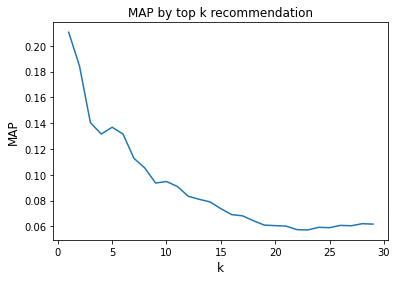

In [ ]:
plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

# MF - sklearn (SVD, SGD, ALS)

## 학습 준비

### rating matrix 만들기

In [ ]:
# user - movie 데이터프레임 생성
user_movie_rating = train.pivot_table('rating', index = 'userId', columns='title').fillna(0)
user_movie_rating.head()

title,!Women Art Revolution,'Gator Bait,'Twas the Night Before Christmas,...And God Created Woman,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1900,1984,2 Days in Paris,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2010,2046,21 Grams,24 Hour Party People,25th Hour,28 Days Later,28 Weeks Later,29th Street,2:37,3 Ninjas: High Noon at Mega Mountain,3-Iron,300,33 Scenes from Life,"4 Months, 3 Weeks and 2 Days",40 Days and 40 Nights,42nd Street,48 Hrs.,5 Card Stud,5 Days of War,50 First Dates,54,7 Virgins,...,Wizards of the Lost Kingdom,Wolves of Wall Street,Woman in the Moon,Woman of the Lake,Women on the Verge of a Nervous Breakdown,Working Girl,World Trade Center,Wuthering Heights,X-Men Origins: Wolverine,X: The Unknown,Xuxa in Crystal Moon,Y Tu Mamá También,Yamakasi,Yankee Doodle Dandy,Yella,Yesterday,You Only Live Twice,You're a Big Boy Now,Young Adam,Young Black Stallion,Young Frankenstein,Young Mr. Lincoln,Young and Innocent,"Young, Violent, Dangerous",Z,Zaat,Zabriskie Point,Zapped Again!,Zardoz,Zatoichi,Zatôichi's Pilgrimage,Zazie dans le métro,Zodiac,Zombie Flesh Eaters,Zombie Holocaust,eXistenZ,xXx,¡Three Amigos!,À nos amours,Ödipussi
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# user - movie 데이터 프레임을 행렬로 변환
rating_matrix = user_movie_rating.values.T
rating_matrix.shape

(2358, 671)

### id에 해당하는 인덱스 찾는 딕셔너리 생성

In [ ]:
user2idx = {}
for i, l in enumerate(train['userId'].unique()):
    user2idx[l] = i
    
movie2idx = {}
for i, l in enumerate(train['movieId'].unique()):
    movie2idx[l] = i

In [ ]:
idx2user = {i: user for user, i in user2idx.items()}
idx2movie = {i: item for item, i in movie2idx.items()}

## SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

SVD = TruncatedSVD(n_components=12)
left = SVD.fit_transform(rating_matrix)
right = SVD.components_
sing = np.diag(SVD.explained_variance_)

In [ ]:
print(f'left : {left.shape}, sing : {sing.shape},  right : {right.shape}')

left : (2358, 12), sing : (12, 12),  right : (12, 671)


In [ ]:
svd_matrix = left.dot(sing).dot(right)
svd_matrix.shape

(2358, 671)

## SGD

### SGD 함수 정의



In [ ]:
from tqdm import tqdm_notebook as tqdm

# Base code : https://yamalab.tistory.com/92
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)

### 학습

### rating matrix를 sparse matrix로

In [ ]:
data = train[['userId', 'movieId']]#.reset_index(drop=True)
useridx = data['useridx'] = train['userId'].apply(lambda x: user2idx[x]).values
movieidx = data['movieId'] = train['movieId'].apply(lambda x: movie2idx[x]).values
rating = train['rating']

rating_sparse = scipy.sparse.csr_matrix((rating, (useridx, movieidx)), shape=(len(set(useridx)), len(set(movieidx))))
rating_matrix = rating_sparse.toarray()

### SGD 학습

In [ ]:
%%time
factorizer = MatrixFactorization(rating_matrix, k = 10, learning_rate=0.1, reg_param=0.1, epochs=100, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 0.7185
Iteration: 20 ; cost = 0.6643
Iteration: 30 ; cost = 0.6418
Iteration: 40 ; cost = 0.6301
Iteration: 50 ; cost = 0.6227
Iteration: 60 ; cost = 0.6181
Iteration: 70 ; cost = 0.6151
Iteration: 80 ; cost = 0.6131
Iteration: 90 ; cost = 0.6116
Iteration: 100 ; cost = 0.6104
CPU times: user 2min 13s, sys: 16.5 s, total: 2min 29s
Wall time: 2min 12s


In [ ]:
sgd_matrix = factorizer.get_complete_matrix()

In [ ]:
# 모델 저장
# np.save('코드/sgd', sgd_matrix)

## ALS

In [ ]:
from implicit.evaluation import  *
from implicit.als import AlternatingLeastSquares as ALS
from implicit.bpr import BayesianPersonalizedRanking as BPR

als_model = ALS(factors=10, regularization=0.1, iterations = 100)
als_model.fit(rating_sparse.T)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
item_factor = als_model.item_factors.to_numpy()
user_factor = als_model.user_factors.to_numpy()

In [ ]:
print(f'item factor : {item_factor.shape}, user factor : {user_factor.shape}')

item factor : (2389, 10), user factor : (671, 10)


In [ ]:
als_matrix = np.dot(user_factor, item_factor.T)

In [ ]:
# 모델 저장
# np.save('코드/als', als_matrix)

# ----------------------------------------------------------
아래에서는 MF 방식으로 구한 Matrix들을(동영)  
태환님 평가함수, 추천함수에 적용
# --------------------------------------------------------


# 평가

## 위 과정 설명
- 위 과정 (SVD, SGD, ALS) 과정들은 user-item 행렬을 학습?하는 과정이었음  
- 행렬 $M : user \times item(movie)$ 의 원소 $M(i, j)$는 $i$번째 $user$가 $j$번째 영화를 얼마나 좋아할 지를 나타냄
- 위에서 구한 `svd_matirx`, `sgd_matrix`, `als_matrix`는 각각의 방법으로 행렬 $M$을 구한 것

- 이제 아래에서 각 방법들로 구한 $M$들로 각 유저에게 영화를 추천해 줄거임

## 함수 정의

### `get_predictions`
- 행렬 $M$에서 각 유저마다 점수가 높은 순으로 영화들을 정렬 후 $top~k$개 만큼 뽑아서 `predictions`에 $(영화제목, 점수)$ 형태로 저장

In [ ]:
matrix = svd_matrix
def get_predictions(matrix, topk=10):
    predictions = {}
    for user in user_movie_df['userId'].unique():
        predicted_rating = [(idx2movie[i], score) for i, score in enumerate(matrix[:, user2idx[user]])]
        predicted_rating = sorted(predicted_rating, key = lambda x : x[1], reverse=True)
        predictions[user] = predicted_rating[:topk]

    return predictions

SVD로 구한 `svd_matrix`에서 prediction 구해 봄

In [ ]:
svd_predictions = get_predictions(svd_matrix)
svd_predictions[7]

[(8016, 13.184025661312571),
 (980, 11.639586854695134),
 (84154, 11.443165216073002),
 (8948, 9.986749077452345),
 (4043, 9.004240648134513),
 (810, 8.621497795384805),
 (2757, 8.308887425529065),
 (2012, 8.273158187709853),
 (140174, 8.061606342598505),
 (8453, 7.848870753554062)]


### `get_user_metric`
- `prefer_list` : `get_predictions`에서 구한 `predictions`(영화제목, 점수) 에서 영화 제목만 추출  
- `actual_watch_list` : test set에서 각 유저가 4점 이상으로 평가한 영화들 모음  
- `user_metric` : 위 내용을 (user, prefer_list, actual_watch_list) 형식으로 저장

In [ ]:
def get_user_metric(predictions, topk=5):
    user_metric = []
    for user in user_movie_df['userId'].unique():
        # 유저가 높게 평가했을 것이라고 예측된 영화
        prefer_list = []
        for pred in predictions[user]:
            prefer_list.append(pred[0])
        # 유저가(테스트셋 내에서) 평점 4점 이상으로 평가한 영화
        actual_watch_list = []
        for id in test[test['userId'] == user][['movieId']][test.rating >= 4].values:
            actual_watch_list.append(id[0])

        user_metric.append((user, prefer_list[:topk], actual_watch_list))
    return user_metric

SVD로 구한 `svd_prediction`으로 `user_metric` 만들기

In [ ]:
svd_user_metric = get_user_metric(svd_predictions)
svd_user_metric[2]

(7, [8016, 980, 84154, 8948, 4043], [1374, 260, 1405])

### `get_map`
- 위에서 계산한 `user_metric`으로 $MAP$ 점수 계산

In [ ]:
# user metric를 인자로 받는 mean average precision 계산하는 함수
def get_map(user_list):
  precision_list = []
  for user in user_list:
    predictive_values = user[1] #높게 평가했을 거라고 예측한 상위 k개 영화중 하나
    actual_values = set(user[2]) #유저가 실제로 4점이상이라고 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #Confusion Matrix를 통한 precision 계산1
    precision = len(tp) / len(predictive_values) ##Confusion Matrix를 통한 precision 계산2 여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 만족했다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list) #유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다

SVD로 구한 `svd_user_metric`의 $MAP$ 점수 구해보기

In [ ]:
get_map(svd_user_metric)

0.00029806259314456036

## SGD, ALS도 추천, 평가

In [ ]:
sgd_predictions = get_predictions(sgd_matrix)
sgd_user_metric = get_user_metric(sgd_predictions)
get_map(sgd_user_metric)

0.006259314456035769

In [ ]:
als_predictions = get_predictions(als_matrix)
als_user_metric = get_user_metric(als_predictions)
get_map(als_user_metric)

0.010432190760059619

## 평가 방식 및 추천 방식에 보완할 부분 많음
- 4점 이상을 기준으로 잡았는데, 애초에 모든 영화를 4점보다 낮게 준 유저는?
    - 그럼 점수 기준이 아니라 각 유저가 좋게 평가한 영화 k개를 뽑아야 하는지?
- 등등

# 영화 추천

- 태환님이 작성하신 함수에 위 평가 과정에서 구한 `user_metric`랑 원하는 `id_num`(user id), `topk`를 입력
- 해당 유저가 4점 이상이라고 평가한 영화 중 상위 k개
- 해당 유저가 좋아할 것이라고 우리가 추천한 영화 k개 출력

In [ ]:
def user_list(user_metric, id_num, topk=5): #i번째 유저가 높게 평가한 영화들과 좋아할거라 예상되는 영화 리스트
    print(f'user_Id: {user_metric[id_num][0]}')
    print('highly rated movie:')
    for i in user_metric[id_num][2][:topk]: print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유저가 4점이상 평가한 영화
    print()
    print('predicted favorite movie:')
    for i in user_metric[id_num][1][:topk]: print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유거 좋아하리라 예측한 영화 k개

- SVD로 영화 추천

In [ ]:
user_list(svd_user_metric, 3)

user_Id: 19
highly rated movie:
- Night on Earth
- Cool Hand Luke
- A River Runs Through It
- The Wrong Trousers
- Escape from New York

predicted favorite movie:
- Law of Desire
- The Pearl Color
- Fanaa
- Shrek the Third
- Adaptation.


- SGD로 영화 추천

In [ ]:
user_list(sgd_user_metric, 3)

user_Id: 19
highly rated movie:
- Night on Earth
- Cool Hand Luke
- A River Runs Through It
- The Wrong Trousers
- Escape from New York

predicted favorite movie:
- Waiter
- Days of Thunder
- The Murderers Are Among Us
- Kill Bill: Vol. 1
- Batman Forever


- ALS로 영화 추천

In [ ]:
user_list(als_user_metric, 3)

user_Id: 19
highly rated movie:
- Night on Earth
- Cool Hand Luke
- A River Runs Through It
- The Wrong Trousers
- Escape from New York

predicted favorite movie:
- Wuthering Heights
- The Contract
- Shortbus
- Dr. Cyclops
- Once in a Lifetime: The Extraordinary Story of the New York Cosmos
